# Data Cleaning 

Analysing the dataset's information we can see that the shared data are the trip duration (although this figure is not always given explicitly but can be calculated by having the time of departure and arrival), the starting and ending station (name or ID), the user type and the bike ID.

These data are not present in all datasets: duration is not present in the newer version of CityBike NYC, in CoGo's trips data and in Divvy's data, start and end times are not present in the Austin MetroBike (it is only present the end time and the duration so we can infer that), start and end stations are not present in the Austin MetroBike and the bike id is not present in Divvy's dataset.
It therefore seems impossible to have data shared by all datasets but those reported to you may be the most important ones to work on.

Another information that is present in some of the dataset are the year of Birth, the gender and the station latitude and longitude. The first two data can be useful for a social analysis on the age and the gender of the user in different cities but this data are only presented in the older version of the CityBike NYC, in BluBike (through ... check) and in CoGo's dataset (randomly, in some months it is present and in others it is not, and it changes format. These data are present only through January 2020).

Starting year of each dataset:
- CityBike NYC, 2013
- BlueBike Boston, 2015
- Capital BikeShare Washington, 2010
- Bay Wheels San Francisco, 2017
- CoGo Columbus, 2018
- Austin MetroBike, 2014 (mixed)
- Divvy Chicago, (2014, incomplete) 2020
- IndeGo Philly, 2015 (incomplete)

Note: 2018-01 Columbus not present, 2018-02 has wrong data

These functions are currently usable with the dataset of NYC, Boston, Washington and San Francisco.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
from datetime import datetime

data_dir = 'D:/unitn/Bike-Inequality/data/NYC'

In [1]:
def get_missing_data(df):
    # Get the number of missing data points per column
    missing_values_count = df.isnull().sum()

    # How many total missing values do we have?
    total_cells = np.prod(df.shape)
    total_missing = missing_values_count.sum()

    # Percent of data that is missing
    percent_missing = (total_missing/total_cells) * 100

    return percent_missing

## Get the duration information
The function get_duration_info() takes a DataFrame, analyzes the data internally and clusters them into five different classes: '< 500', '< 1000', '< 10000', '< 100000' and '> 100000'.

In [4]:
def get_duration_info(df, number, axs, fig, file):
    '''
    function to get the duration information for each file, cluster them and plot the frequency of each cluster
    '''
    durations = get_time(file, df, number)

    # Define a function to determine the cluster for each number
    def get_cluster(num):
        if type(num) == str:
            num = int(float(num.replace(',', '')))
        if num < 500:
            return "<500"
        elif num < 1000:
            return "<1000"
        elif num < 10000:
            return "<10000"
        elif num < 100000:
            return "<100000"
        else:
            return ">100000"

    # Group numbers into clusters
    clusters = [get_cluster(num) for num in durations]

    # Calculate frequency of each cluster
    frequency = Counter(clusters)

    # Extract cluster names and their frequencies
    for key in frequency:
        frequency[key] /= sum(frequency.values())
    
    return frequency

def prepare_plot(axs, fig, frequency, number):
    x = number // 3
    y = number % 3
    cluster_names = list(frequency.keys())
    cluster_frequencies = list(frequency.values())
    axs[x, y].bar(cluster_names, cluster_frequencies)
    for index in range(len(cluster_names)):
        axs[x, y].text(index, cluster_frequencies[index], str(round(cluster_frequencies[index], 5)), ha='center')

    # Add labels and title
    for ax in axs.flat:
        ax.set(xlabel='Trip duration', ylabel='Frequency')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()
    fig.suptitle('Frequency of Trip Duration')

# Data Analysis
## Monthly duration frequency of ride 
Data is divided into multiple file so we need to integrate in a single file the data of a single month in order to evaluate them together.

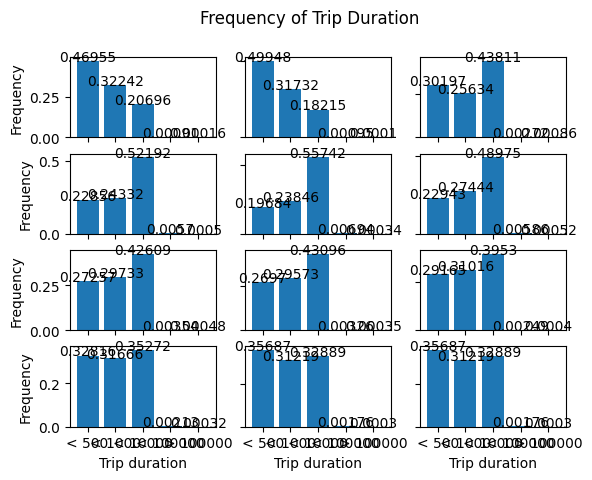

In [8]:
def data_for_month(data_dir):

    data_files = os.listdir(data_dir)
    month = 0

    fig, ax = plt.subplots(4, 3)

    for file in data_files:
        # read data from each file into a DataFrame
        file_path = os.path.join(data_dir, file)
        df = pd.read_csv(file_path)
        
        if data_dir[:11] == 'data\\Philly':
            for _ in range(3):
                frequency = get_duration_info(df, month, ax, fig, data_dir)
                prepare_plot(ax, fig, frequency, month)
                month += 1
        else:
            month = int(file[4:6]) - 1
            frequency = get_duration_info(df, month, ax, fig, data_dir)
            prepare_plot(ax, fig, frequency, month)
    
    plt.title(data_dir)
    plt.show()

data_for_month(data_dir)

## Yearly duration frequency
The function data_for_year() take the data from each file and return the frequency for each ride duration interval.

In [ ]:
def data_for_year(data_dir):
    '''
    function to plot the data for each year
    '''

    fig, ax = plt.subplots(2, 3)
    yearly_frequency = {
        '<500': 0,
        '<1000': 0,
        '<10000': 0,
        '<100000': 0,
        '>100000': 0
    }
    
    
    for year in os.listdir(data_dir):
        year_path = os.path.join(data_dir, year)
        for file in os.listdir(year_path):
            file_path = os.path.join(year_path, file)
            df = pd.read_csv(file_path)
            frequency = get_duration_info(df, year, ax, fig, data_dir)
            for key in frequency:
                yearly_frequency[key] += frequency[key]
        year = int(year) - 2018
        for key in yearly_frequency:
            yearly_frequency[key] /= sum(yearly_frequency.values())
        prepare_plot(ax, fig, yearly_frequency, year)
        frequency.clear()
    
    # Show plot
    plt.show()

## Gender analysis
The function data_integration_for_gender() take the data from each file and count how many people for each gender there are in it and add it to the dictionary genders_infos.
At the end plot the data with a pie chart.

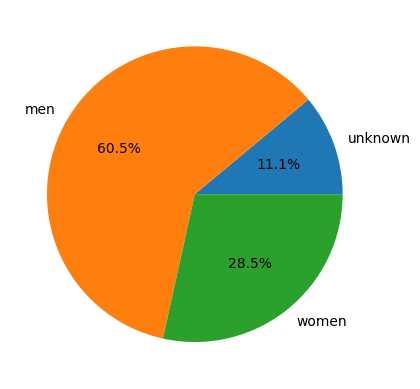

In [4]:
def data_for_gender(data_dir):

    data_files = os.listdir(data_dir)
    genders_infos = {
        'unknown': 0,
        'men': 0,
        'women': 0,
    }

    for file in data_files:
        # read data from each file into a DataFrame
        file_path = os.path.join(data_dir, file)
        
        df = pd.read_csv(file_path)
        count = df['gender'].value_counts()
        genders_infos['unknown'] += count[0]
        genders_infos['men'] += count[1]
        genders_infos['women'] += count[2]
    
    fig, ax = plt.subplots()
    plt.pie(genders_infos.values(), labels=genders_infos.keys(),  autopct='%1.1f%%')
    plt.show()
    
data_for_gender()

## User Type analysis
The function data_integration_for_usertype() take the data from each file and count how many people for each subscription there are in it and add it to the dictionary usertypes_infos.
At the end plot the data with a pie chart.

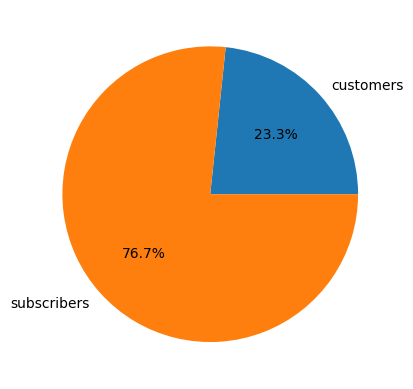

In [4]:
def data_for_usertype(data_dir):
    data_files = os.listdir(data_dir)
    usertypes_infos = {
        'customers': 0,
        'subscribers': 0,
    }

    for file in data_files:
        # read data from each file into a DataFrame
        file_path = os.path.join(data_dir, file)
        
        df = pd.read_csv(file_path)
        count = df['usertype'].value_counts()
        usertypes_infos['customers'] += count['Customer']
        usertypes_infos['subscribers'] += count['Subscriber']
    
    fig, ax = plt.subplots()
    plt.pie(usertypes_infos.values(), labels=usertypes_infos.keys(),  autopct='%1.1f%%')
    plt.show()
    
data_for_usertype()